In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import random
from pathlib import Path

import chess
import iceberg as ice
import matplotlib.pyplot as plt
import numpy as np
import torch
from leela_interp import Lc0Model, Lc0sight, LeelaBoard
from leela_interp.core.iceberg_board import palette
from leela_interp.tools import figure_helpers as fh
from leela_interp.tools.piece_movement_heads import (
    bishop_heads,
    knight_heads,
    rook_heads,
)

In [3]:
with open("interesting_puzzles.pkl", "rb") as f:
    puzzles = pickle.load(f)
len(puzzles)

22517

In [22]:
puzzles = puzzles[:10]

# Count parameters

In [23]:
small_model = Lc0Model("LD2.onnx", device="cpu")
model = Lc0Model("lc0.onnx", device="cpu")

Using device: cpu
Using device: cpu


Leela's parameters are not `nn.Parameter` objects, so they are not counted by `model.parameters()`.
So we have our own helper function to count them:

In [24]:
def count_params(model):
    i = 0
    n_params = 0
    while True:
        try:
            param = getattr(model._lc0_model.initializers, f"onnx_initializer_{i}")
        except AttributeError:
            break
        n_params += param.numel()
        i += 1
    return n_params


print(f"Small model has {count_params(small_model):,} parameters")
print(f"Large model has {count_params(model):,} parameters")

Small model has 390,341 parameters
Large model has 109,080,617 parameters


In [25]:
del model
del small_model

# Subsplits

In [26]:
figure_dir = Path("figures")
figure_dir.mkdir(exist_ok=True)
different_targets_dir = figure_dir / "different_targets"
different_targets_dir.mkdir(exist_ok=True)
same_targets_dir = figure_dir / "same_targets"
same_targets_dir.mkdir(exist_ok=True)

In [27]:
boards = [LeelaBoard.from_puzzle(puzzle) for _, puzzle in puzzles.iterrows()]
first_target_squares = [
    puzzle.principal_variation[0][2:4] for _, puzzle in puzzles.iterrows()
]
second_target_squares = [
    puzzle.principal_variation[1][2:4] for _, puzzle in puzzles.iterrows()
]
third_target_squares = [
    puzzle.principal_variation[2][2:4] for _, puzzle in puzzles.iterrows()
]
first_target_indices = np.array(
    [board.sq2idx(square) for board, square in zip(boards, first_target_squares)]
)
second_target_indices = np.array(
    [board.sq2idx(square) for board, square in zip(boards, second_target_squares)]
)
third_target_indices = np.array(
    [board.sq2idx(square) for board, square in zip(boards, third_target_squares)]
)

In [28]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")
model = Lc0sight("lc0.onnx", device=device)

Using device: cpu


In [29]:
different_targets_mask = puzzles["different_targets"].to_numpy().astype(bool)
same_targets_mask = ~different_targets_mask
print(f"Same targets: {same_targets_mask.sum()} ({same_targets_mask.mean():.2%})")
print(
    f"Different targets: {different_targets_mask.sum()} ({different_targets_mask.mean():.2%})"
)

Same targets: 8 (80.00%)
Different targets: 2 (20.00%)


# Log-odds helper
Just a helper function for converting between log odds and probabilities.

In [30]:
def prob_to_logodds(prob):
    return np.log(prob / (1 - prob))


def logodds_to_prob(logodds):
    return 1 / (1 + np.exp(-logodds))

In [31]:
logodds_to_prob(prob_to_logodds(0.5) - 1)

0.2689414213699951

# Corruptions
This lets us look at the automatically generated corruptions.

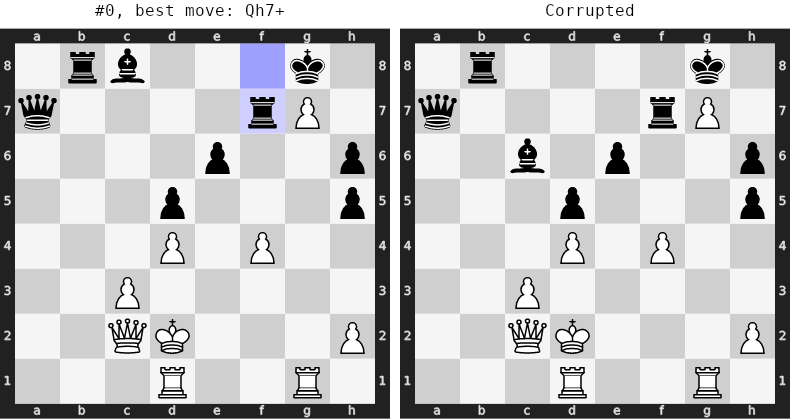

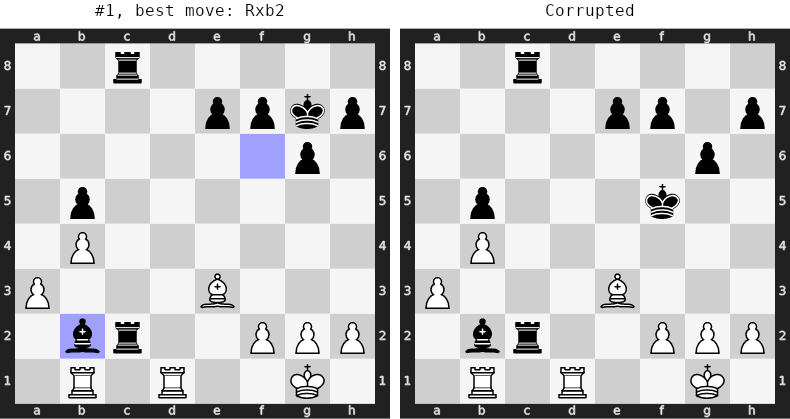

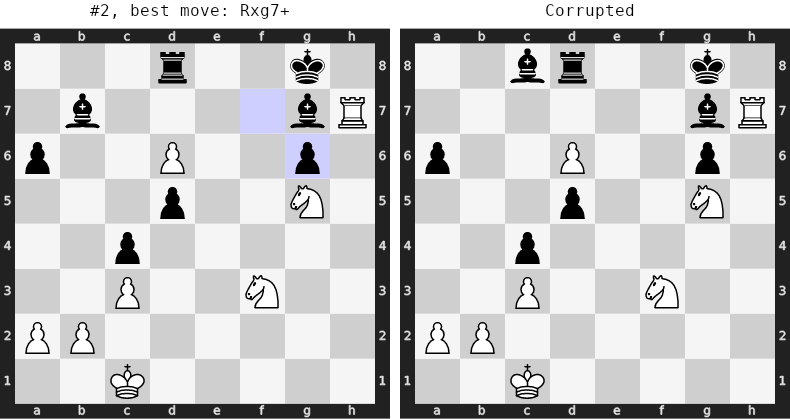

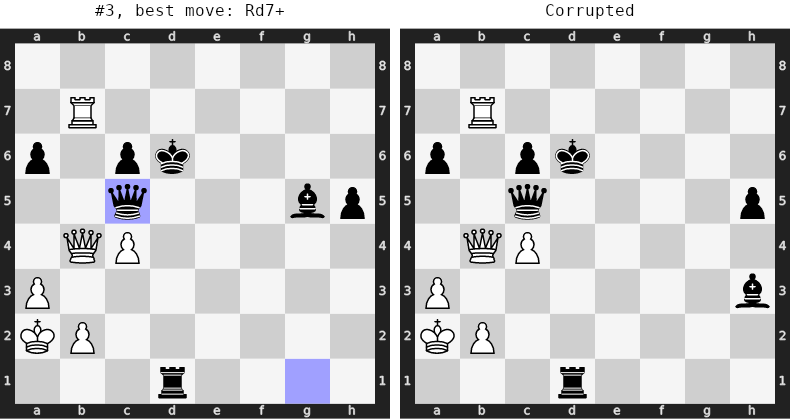

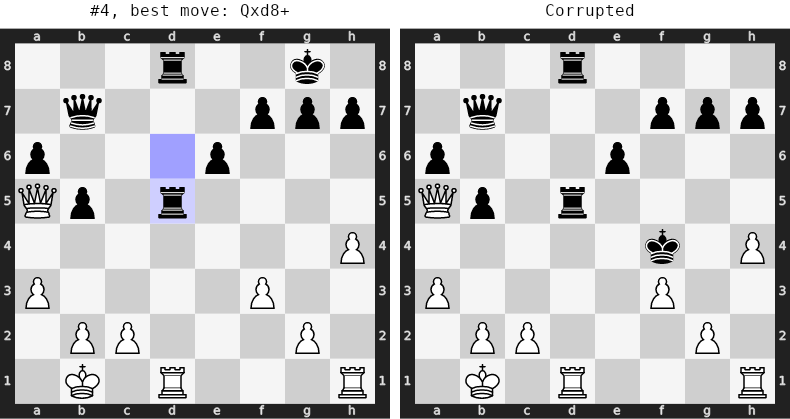

In [32]:
for i in range(5):
    puzzle = puzzles.iloc[i]
    board = LeelaBoard.from_puzzle(puzzle)
    plot1 = board.plot(
        caption=f"#{i}, best move: {board.pc_board.san(chess.Move.from_uci(puzzle.principal_variation[0]))}"
    )
    plot2 = LeelaBoard.from_fen(puzzle.corrupted_fen).plot(caption="Corrupted")
    display(ice.Arrange([plot1, plot2], gap=10))

# Global activation patching

## Residual stream

In [55]:
all_effects = -torch.load(
    "results/global_patching/residual_stream_results.pt", map_location=device
)
all_effects.shape

/tmp/ipykernel_513724/232512628.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_effects = -torch.load(


torch.Size([10, 15, 64])

In [17]:
def plot_examples(mask=None, n=5):
    if mask is None:
        mask = np.ones(len(puzzles), dtype=bool)

    effects = all_effects[mask]

    plots = []

    # Don't plot all the layers, it's too much
    layers = [0, 6, 8, 10, 12, 14]

    for i in range(n):
        board = LeelaBoard.from_puzzle(puzzles[mask].iloc[i])
        colormap_values, mappable = palette(
            effects[i][layers].cpu().numpy().ravel(),
            cmap="bwr",
            zero_center=True,
        )
        colormap_values = [
            colormap_values[j : j + 64] for j in range(0, 64 * len(layers), 64)
        ]
        new_plots = []
        for j, layer in enumerate(layers):
            max_effect_idx = effects[i, layer].abs().argmax()
            max_effect = effects[i, layer, max_effect_idx].item()
            new_plots.append(
                board.plot(
                    heatmap=colormap_values[j],
                    caption=f"L{layer}, max log odds reduction: {max_effect:.2f}",
                )
            )

        plots.append(ice.Arrange(new_plots, gap=10))

    return ice.Arrange(plots, gap=10, arrange_direction=ice.Arrange.Direction.VERTICAL)

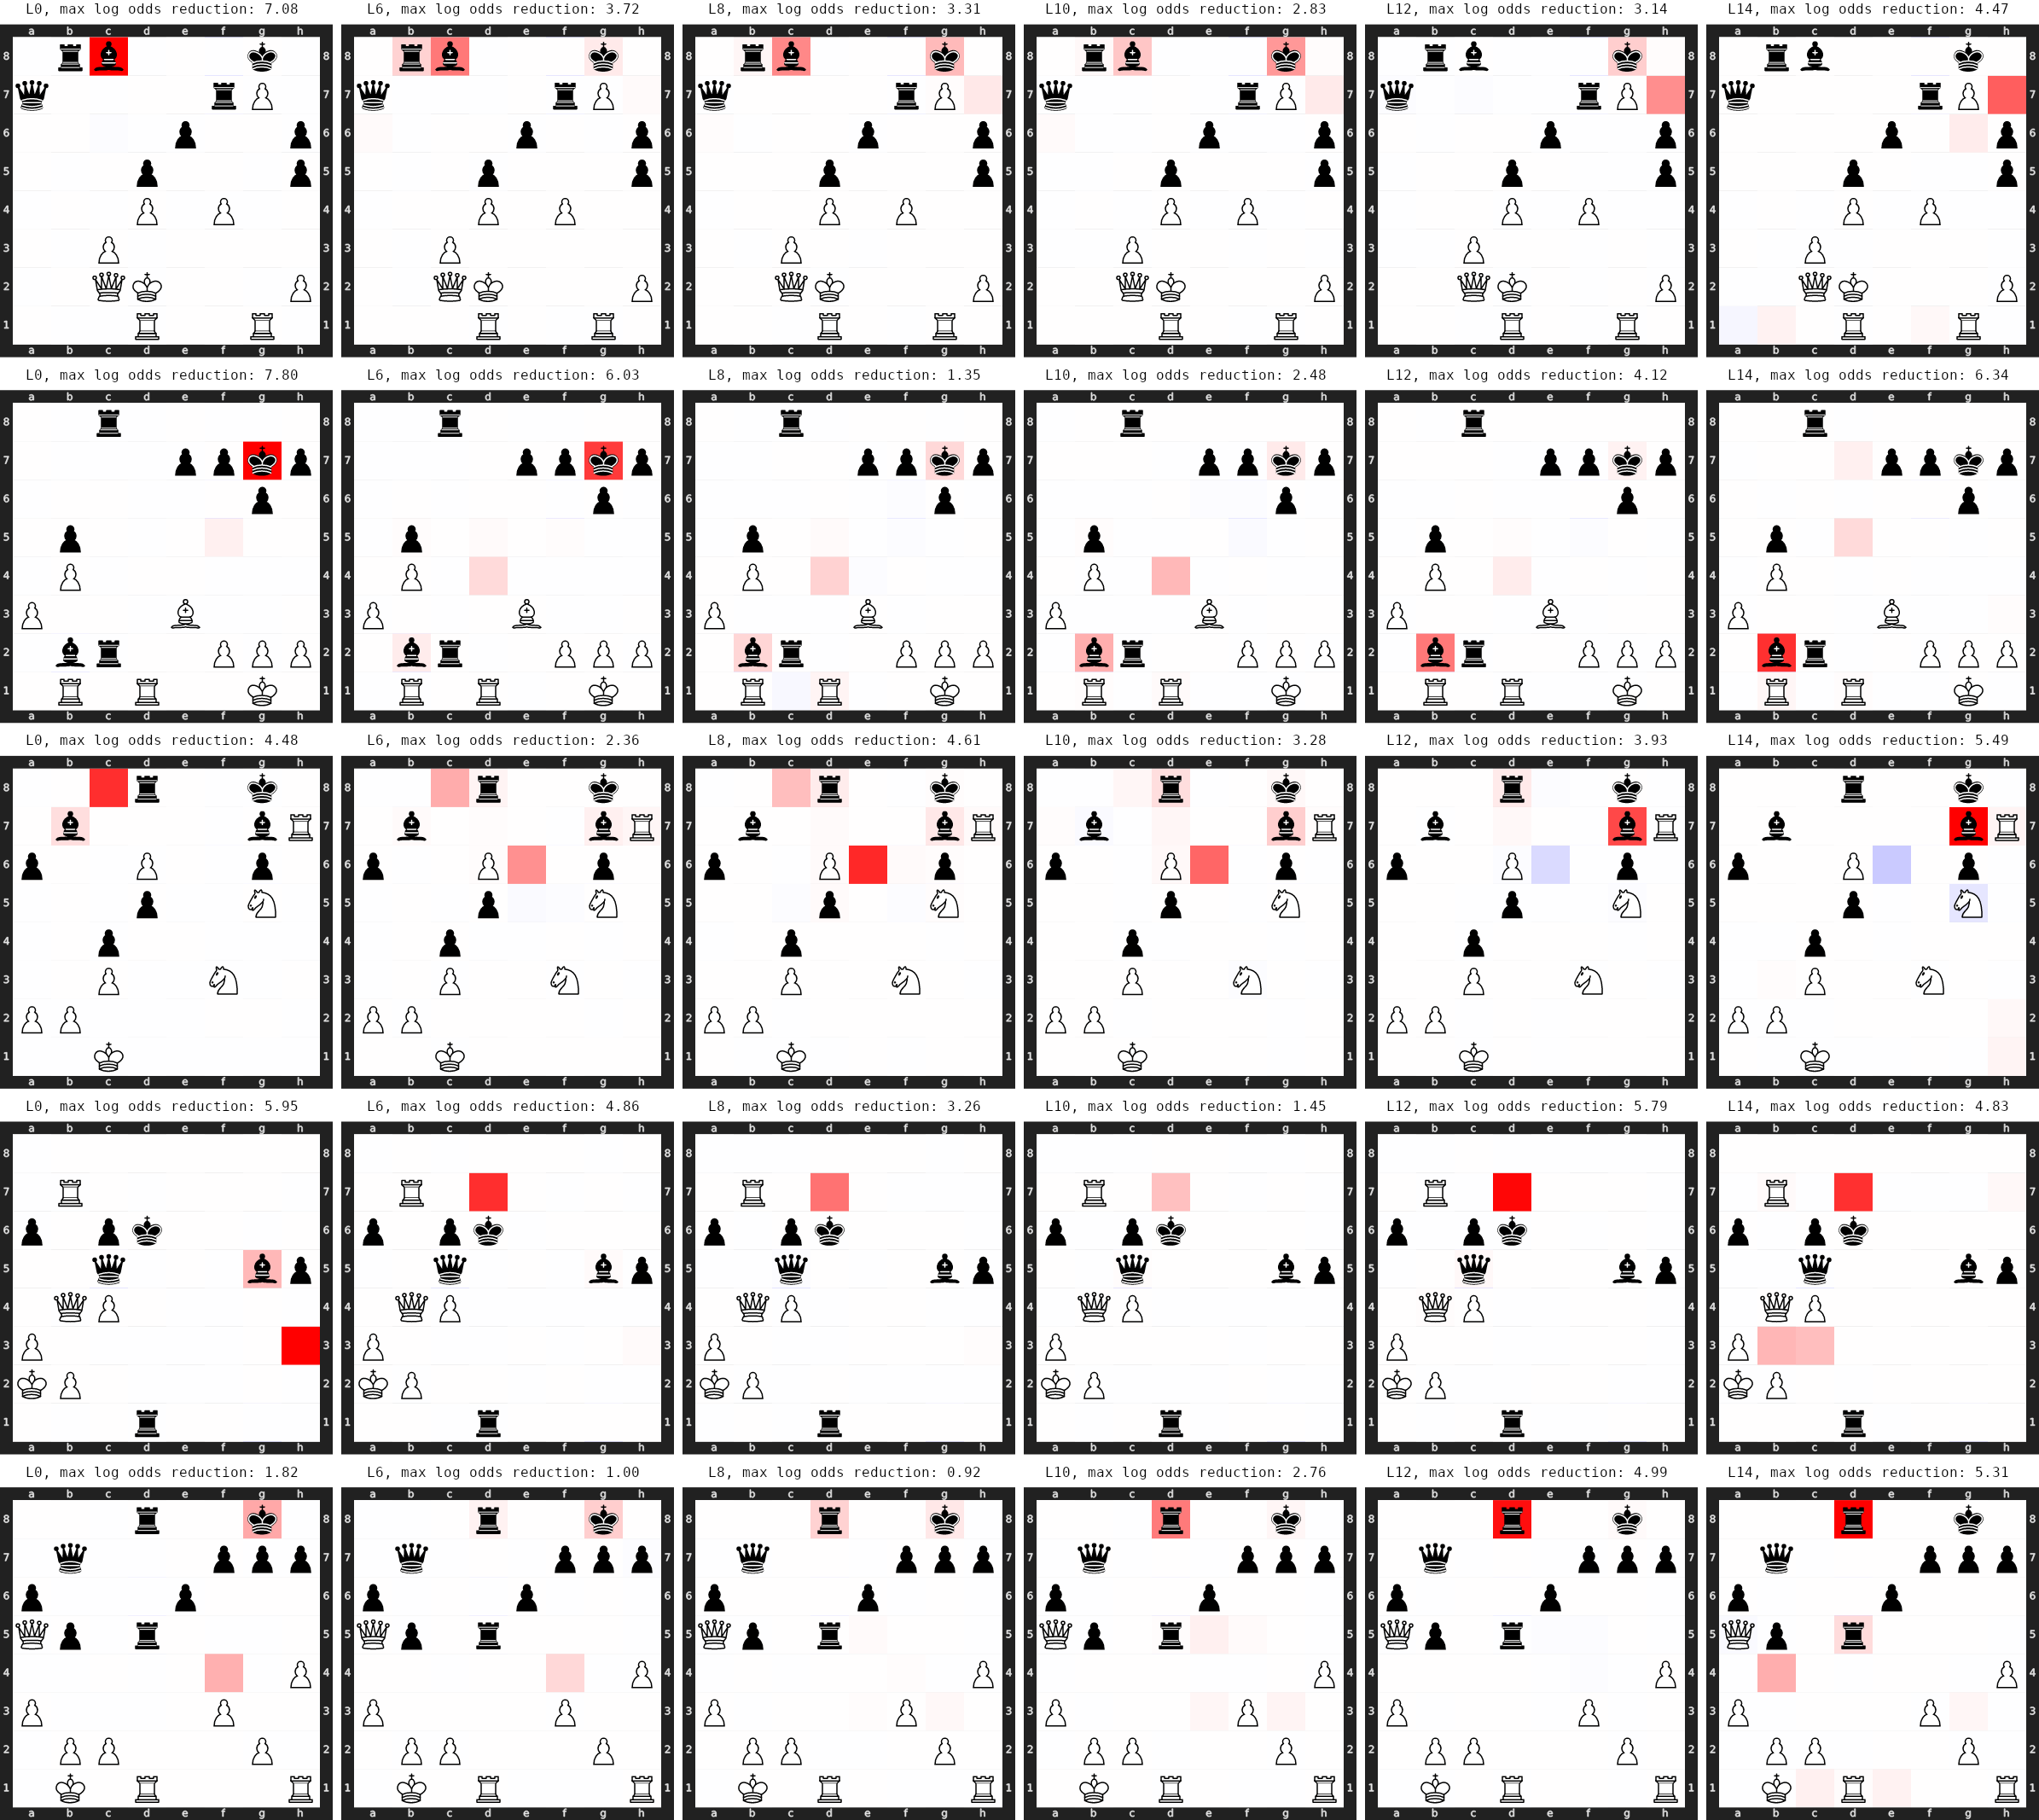

In [34]:
plot_examples(n=5)

In [56]:
def get_effects_data(mask=None):
    if mask is None:
        mask = np.ones(len(puzzles), dtype=bool)

    effects = all_effects[mask]

    candidate_effects = []
    follow_up_effects = []
    patching_square_effects = []
    other_effects = []
    skipped = []
    non_skipped = []

    for i, (idx, puzzle) in enumerate(puzzles[mask].iterrows()):
        # Should never happen on hard puzzles
        if len(puzzle.principal_variation) < 3:
            skipped.append(idx)
            continue
        if puzzle.sparring_full_pv_probs[1] < 0.5:
            skipped.append(idx)
            continue
        board = LeelaBoard.from_puzzle(puzzle)
        corrupted_board = LeelaBoard.from_fen(puzzle.corrupted_fen)

        # Figure out which square(s) differ in the corrupted position
        patching_squares = []
        for square in chess.SQUARES:
            if board.pc_board.piece_at(square) != corrupted_board.pc_board.piece_at(
                square
            ):
                patching_squares.append(chess.SQUARE_NAMES[square])

        candidate_squares = [puzzle.principal_variation[0][2:4]]
        follow_up_squares = [puzzle.principal_variation[2][2:4]]

        # We count squares later than the 3rd one as follow-up squares too:
        for move in puzzle.principal_variation[3:]:
            follow_up_squares.append(move[2:4])

        if (
            set(patching_squares).intersection(set(candidate_squares))
            or set(patching_squares).intersection(set(follow_up_squares))
            or set(candidate_squares).intersection(set(follow_up_squares))
        ):
            skipped.append(idx)
            continue

        non_skipped.append(idx)
        candidate_effects.append(
            effects[i, :, [board.sq2idx(square) for square in candidate_squares]]
            .amax(-1)
            .cpu()
            .numpy()
        )
        follow_up_effects.append(
            effects[i, :, [board.sq2idx(square) for square in follow_up_squares]]
            .amax(-1)
            .cpu()
            .numpy()
        )
        patching_square_effects.append(
            effects[i, :, [board.sq2idx(square) for square in patching_squares]]
            .amax(-1)
            .cpu()
            .numpy()
        )
        covered_squares = set(patching_squares + candidate_squares + follow_up_squares)
        other_effects.append(
            effects[
                i,
                :,
                [idx for idx in range(64) if board.idx2sq(idx) not in covered_squares],
            ]
            .amax(-1)
            .cpu()
            .numpy()
        )

    print(
        f"Skipped {len(skipped)} out of {mask.sum()} puzzles ({len(skipped)/mask.sum():.2%})"
    )

    candidate_effects = np.stack(candidate_effects)
    follow_up_effects = np.stack(follow_up_effects)
    patching_square_effects = np.stack(patching_square_effects)
    other_effects = np.stack(other_effects)

    # Define lists for effects and their configurations
    return [
        {"effects": candidate_effects, "name": "1st move target"},
        {"effects": follow_up_effects, "name": "3rd move target"},
        {"effects": patching_square_effects, "name": "Patching square(s)"},
        {"effects": other_effects, "name": "Other squares"},
    ], non_skipped

In [63]:
effects_data, _ = get_effects_data()

Skipped 4 out of 10 puzzles (40.00%)


In [76]:
all_effects.shape

torch.Size([10, 15, 64])

In [71]:
effects_data

[{'effects': array([[-5.81741333e-05, -1.23858452e-04, -9.61387157e-03,
          -2.27022171e-02,  5.59570789e-02,  1.30386829e-01,
           1.22929215e-01,  2.65049636e-01,  6.15119696e-01,
           5.73331296e-01,  5.86252749e-01,  9.18147087e-01,
           3.14268684e+00,  4.29694700e+00,  4.46944618e+00],
         [ 7.15875626e-03,  1.50549412e-02, -5.25300503e-02,
           2.61960030e-02,  6.29639626e-03,  2.30402946e-01,
           3.06472898e-01,  6.87305331e-01,  4.91122782e-01,
           6.13674045e-01,  1.06824839e+00,  1.44202673e+00,
           3.93140912e+00,  4.49722242e+00,  5.48909998e+00],
         [-3.07559967e-05,  5.92660904e-03,  4.12297249e-03,
           7.64775276e-03,  1.29709244e-02,  3.57240677e+00,
           4.85593414e+00,  2.53225493e+00,  3.25779104e+00,
           1.98091483e+00,  1.45459569e+00,  4.18358278e+00,
           5.79025078e+00,  4.82570553e+00,  4.82878113e+00],
         [-3.26895714e-03,  1.18255615e-04,  6.12270832e-03,
          

In [75]:
effects_data[0]["effects"].shape

(6, 15)

In [72]:
def plot_residual_effects(mask=None, save_path=None):
    if mask is None:
        mask = np.ones(len(puzzles), dtype=bool)

    effects_data, _ = get_effects_data(mask)

    fh.set()

    colors = ["b", "g", "r", "c"]
    layers = list(range(15))

    # Create plots using matplotlib
    fig, ax = plt.subplots()
    fig.set_figwidth(6)
    fig.set_figheight(3)

    colors = fh.COLORS
    # line_styles = ["-", "-", "-", "--"]
    line_styles = ["-"] * 4

    for i, effect_data in enumerate(effects_data):
        effects = effect_data["effects"]
        mean_effects = np.mean(effects, axis=0)
        # 2 sigma error bars
        stderr_effects = 2 * np.std(effects, axis=0) / np.sqrt(len(effects))

        ax.plot(
            layers,
            mean_effects,
            label=effect_data["name"],
            color=colors[i],
            linestyle=line_styles[i],
            linewidth=fh.LINE_WIDTH,
        )
        ax.fill_between(
            layers,
            mean_effects - stderr_effects,
            mean_effects + stderr_effects,
            color=colors[i],
            alpha=fh.ERROR_ALPHA,
        )

    # ax.set_title("Patching effects on different squares by layer")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Log odds reduction of correct move")
    _, y_max = ax.get_ylim()
    ax.set_ylim(0, y_max)
    ax.legend()
    ax.spines[["right", "top", "left"]].set_visible(False)
    ax.set_facecolor(fh.PLOT_FACE_COLOR)

    if save_path is not None:
        fh.save(save_path, fig)

In [73]:
effects_data, _ = get_effects_data()

Skipped 4 out of 10 puzzles (40.00%)


Skipped 4 out of 10 puzzles (40.00%)


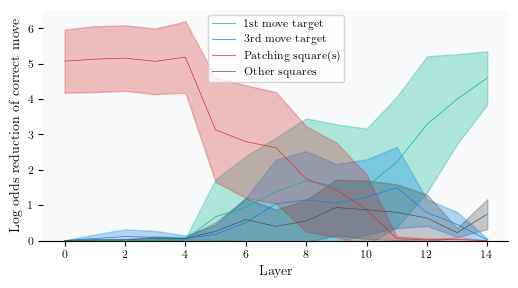

In [74]:
plot_residual_effects()

In [39]:
for i, effect_data in enumerate(effects_data):
    effects = effect_data["effects"]
    mean_effects = np.mean(effects, axis=0)
    stderr_effects = np.std(effects, axis=0) / np.sqrt(len(effects))
    print(
        f"{effect_data['name']}: {mean_effects[10]:.2f} ± {2 * stderr_effects[10]:.2f}"
    )

1st move target: 1.53 ± 1.64
3rd move target: 1.23 ± 1.07
Patching square(s): 0.88 ± 0.99
Other squares: 0.87 ± 0.83


Skipped 0 out of 2 puzzles (0.00%)


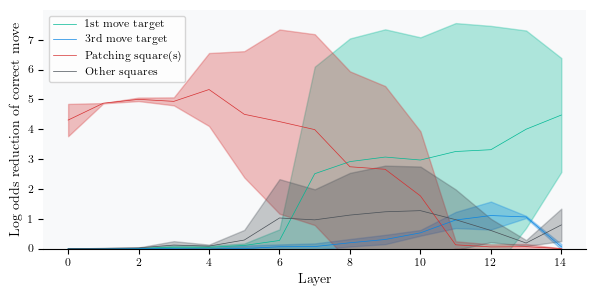

In [40]:
plot_residual_effects(
    mask=different_targets_mask,
    save_path=different_targets_dir / "residual_stream_patching.pdf",
)

Skipped 4 out of 8 puzzles (50.00%)


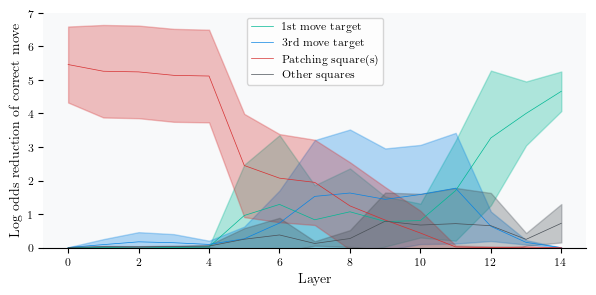

In [41]:
plot_residual_effects(
    mask=same_targets_mask, save_path=same_targets_dir / "residual_stream_patching.pdf"
)

## Attention heads

In [42]:
all_effects = torch.load(
    "results/global_patching/attention_head_results.pt", map_location=device
)
all_effects.shape

/tmp/ipykernel_513724/1097879826.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_effects = torch.load(


torch.Size([10, 15, 24])

In [43]:
def plot_attention_effects(mask=None):
    if mask is None:
        mask = np.ones(len(all_effects), dtype=bool)
    effects = all_effects[mask]

    mean_effects = -effects.mean(dim=0)
    fh.set()
    plt.figure(figsize=(fh.get_width(0.3), 2))
    plt.imshow(mean_effects.cpu().numpy().T, cmap=fh.EFFECTS_CMAP_2)
    plt.title("Mean patching effects")
    plt.ylabel("Head")
    plt.xlabel("Layer")
    plt.colorbar(fraction=0.10)

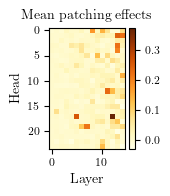

In [44]:
plot_attention_effects()
fh.save("figures/attention_head_patching.pdf")

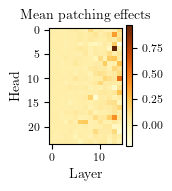

In [45]:
plot_attention_effects(mask=different_targets_mask)
fh.save(different_targets_dir / "attention_head_patching.pdf")

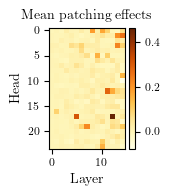

In [46]:
plot_attention_effects(mask=same_targets_mask)
fh.save(same_targets_dir / "attention_head_patching.pdf")

# L12H12

In [ ]:
third_to_first_effects = torch.load(
    "results/L12H12/third_to_first_ablation.pt", map_location=device
)
other_effects = torch.load("results/L12H12/other_ablation.pt", map_location=device)
print(third_to_first_effects.shape, other_effects.shape)

In [ ]:
def plot_ablation_effects(mask=None):
    if mask is None:
        mask = slice(None)

    data = {}
    _third_to_first_effects = third_to_first_effects[mask]
    _other_effects = other_effects[mask]

    data[r"3rd$\to$1st target"] = _third_to_first_effects.cpu().numpy()

    data["Other"] = _other_effects.cpu().numpy()

    colors = {
        r"3rd$\to$1st target": fh.COLORS[0],
        "Other": fh.COLORS[-1],
    }

    fh.set()
    return fh.plot_percentiles(
        data,
        zoom_start=94,
        zoom_width_ratio=0.7,
        colors=colors,
        title="Attention ablation effects",
        figsize=(fh.get_width(0.66), 2),
        tick_frequency=25,
        zoom_tick_frequency=2,
        y_lower=-1,
    )

In [ ]:
fig = plot_ablation_effects()
fh.save("figures/L12H12_ablation.pdf", fig=fig)

In [ ]:
fig = plot_ablation_effects(mask=different_targets_mask)
fh.save(different_targets_dir / "L12H12_ablation.pdf", fig=fig)
fig = plot_ablation_effects(mask=same_targets_mask)
fh.save(same_targets_dir / "L12H12_ablation.pdf", fig=fig)

# Probing

In [ ]:
SETTING_TO_PRETTY_NAME = {
    "main": "Probe on trained model",
    "random_model": "Probe on random model",
}


def plot_probe_results(split="all"):
    fh.set(fast=False)
    plt.figure(figsize=(fh.HALF_WIDTH, 2))

    for i, setting in enumerate(["main", "random_model"]):
        results = np.zeros((15, 5))
        for seed in range(5):
            with open(f"results/probing/{split}/{seed}/{setting}.pkl", "rb") as f:
                new_results = pickle.load(f)
                results[:, seed] = new_results["accuracies"]

        means = results.mean(1)
        squared_seed_errors = results.var(1) / results.shape[1]
        # Size of the eval dataset is 30% of all puzzles
        squared_acc_errors = means * (1 - means) / (0.3 * len(puzzles))
        # 2 sigma errors
        errors = 2 * np.sqrt(squared_seed_errors + squared_acc_errors)

        max_layer = means.argmax()

        print(
            f"Max accuracy ({setting}, L{max_layer}): {means[max_layer]:.2f} +- {errors[max_layer]:.2f}"
        )
        plt.plot(
            means,
            label=SETTING_TO_PRETTY_NAME[setting],
            color=fh.COLORS[i],
            linewidth=fh.LINE_WIDTH,
        )
        plt.fill_between(
            range(15),
            means - errors,
            means + errors,
            color=fh.COLORS[i],
            alpha=fh.ERROR_ALPHA,
            linewidth=0,
        )

    plt.title("Third move prediction")
    plt.xlabel("Layer")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.ylim(0, 1.0)
    plt.xlim(0, 14)
    plt.gca().spines[:].set_visible(False)
    plt.gca().set_facecolor(fh.PLOT_FACE_COLOR)
    plt.grid(linestyle="--")
    plt.grid(which="minor", alpha=0.3, linestyle="--")

In [ ]:
plot_probe_results()
fh.save("figures/probing.pdf")

In [ ]:
plot_probe_results(split="different_targets")
fh.save(different_targets_dir / "probing.pdf")
plot_probe_results(split="same_targets")
fh.save(same_targets_dir / "probing.pdf")

# Piece movement heads

In [ ]:
len(knight_heads), len(bishop_heads), len(rook_heads)

In [ ]:
N = 4
patterns = torch.zeros(N, 15, 24, 64, 64, device=device)

boards = [LeelaBoard.from_puzzle(p) for _, p in puzzles.sample(N).iterrows()]

with model.trace(boards):
    for layer in range(15):
        patterns[:, layer] = model.attention_scores(layer).output.save()

In [ ]:
query_indices = random.sample(range(64), N)
plt.figure(figsize=(fh.HALF_WIDTH, 2))
layer = 5

layer_bishop_heads = [head for _layer, head in bishop_heads if _layer == layer]
layer_knight_heads = [head for _layer, head in knight_heads if _layer == layer]
layer_rook_heads = [head for _layer, head in rook_heads if _layer == layer]

if not (layer_bishop_heads and layer_knight_heads and layer_rook_heads):
    raise ValueError("No good heads in this layer, pick a different one")

bishop_head = random.choice(layer_bishop_heads)
knight_head = random.choice(layer_knight_heads)
rook_head = random.choice(layer_rook_heads)

fh.set()

for row, (name, head) in enumerate(
    zip(["Bishop", "Knight", "Rook"], [bishop_head, knight_head, rook_head])
):
    for i in range(N):
        plt.subplot(3, N, row * N + i + 1)
        if i == 0:
            plt.ylabel(
                name,
                rotation=90,
                labelpad=10,
                verticalalignment="center",
            )
        plt.imshow(
            patterns[i, layer, head, query_indices[i], :].cpu().numpy().reshape(8, 8),
            cmap="Oranges",
        )
        plt.xticks([])
        plt.yticks([])
fh.save("figures/piece_movement_patterns.pdf")

In [ ]:
save_dir = Path("results/piece_movement_heads")
data = torch.load(save_dir / "effects.pt", map_location=device)
effects = data["effects"]
piece_movement_mask = data["mask"]

In [ ]:
def plot_piece_movement_ablation(mask=None):
    if mask is None:
        mask = slice(None)
    else:
        mask = mask[piece_movement_mask]
    data = {}
    colors = {}
    for i, name in enumerate(["Main ablation", "Other piece types", "Random square"]):
        data[name] = effects[("key", name)].squeeze().cpu().numpy()[mask]
        colors[name] = fh.COLORS[i]
    fh.set()
    fh.plot_percentiles(
        data,
        title="Piece movement head ablation",
        colors=colors,
        figsize=(fh.HALF_WIDTH, 2),
        y_lower=-1,
        tick_frequency=25,
        y_ticks=[0, 2, 4, 6, 8],
    )

In [ ]:
plot_piece_movement_ablation()
fh.save("figures/piece_movement_ablation.pdf")

In [ ]:
plot_piece_movement_ablation(mask=different_targets_mask)
fh.save(different_targets_dir / "piece_movement_ablation.pdf")
plot_piece_movement_ablation(mask=same_targets_mask)
fh.save(same_targets_dir / "piece_movement_ablation.pdf")

# Positional encodings
These are the domain-specific positional encodings used by Leela.

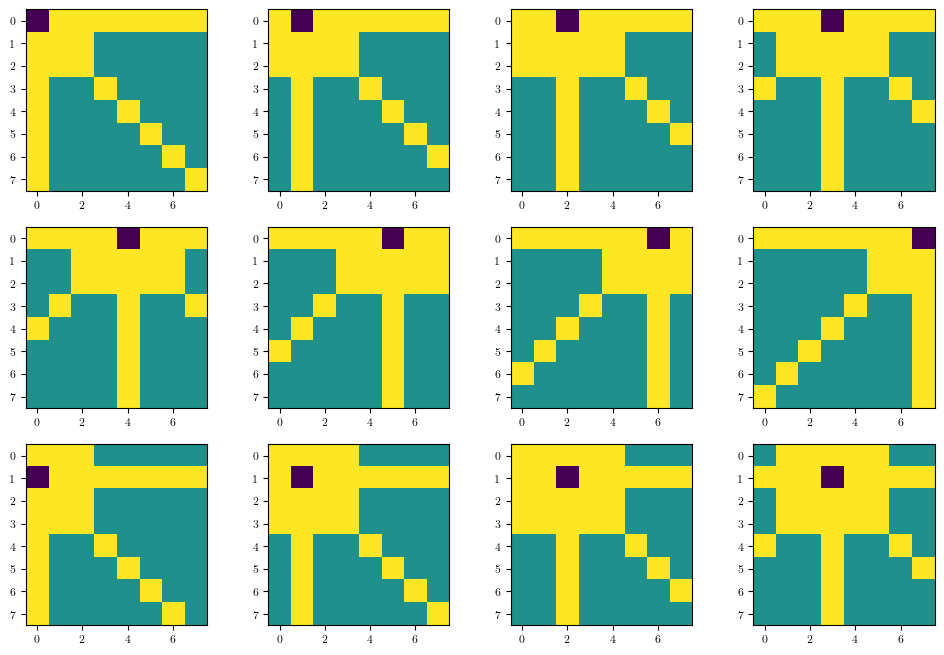

In [47]:
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(
        model._lc0_model.initializers.onnx_initializer_4.cpu()
        .numpy()[0, i]
        .reshape(8, 8)
    )

plt.show()